In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.spatial.distance import correlation as dcorrelation
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")
%matplotlib inline

In [149]:
class Scaler:
    
    def __init__(self):
        self._mu = 0
        self._std = 0
    
    def fit(self, x):
        self._mu = np.mean(x)
        self._std = np.std(x)
    
    def transform(self, x):
        y = np.copy(x)
        return (y - self._mu) / self._std
    
    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)
    
    def inverse(self, x):
        y = np.copy(x)
        return (y * self._std) + self._mu
    
    def __repr__(self):
        return f"{self._mu}, {self._std}"
    

class Normalizer:
    
    def __init__(self):
        self._min = 0
        self._max = 0
    
    def fit(self, x):
        self._min = np.min(x)
        self._max = np.max(x)
    
    def transform(self, x):
        y = np.copy(x)
        return (y - self._min) / (self._max - self._min)

    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)
    
    def inverse(self, x):
        y = np.copy(x)
        return (y * (self._max - self._min)) + self._min 
        
    def __repr__(self):
        return f"{self._min}, {self._max}"   
    
    
class LinearRegressionImpl:
    
    def __init__(self, fit_intercept=True, reg=1e-20, weights=None):
        self.w = weights
        self.fit_intercept = fit_intercept
        self._reg = reg
    
    def mse(self, y, yh):
        N = y.shape[0]
        L2 = (self._reg / (2 * N)) * np.sum([np.sum(np.square(w)) for w in self.w])
        return ((1 / N) * np.sum(np.square(y - yh))) + L2
    
    def _correct_X(self, X):
        if self.fit_intercept:
            X = np.c_[np.ones(X.shape[0]), X]
        return X
    
    def train(self, X, y):
        X = self._correct_X(X)
        
        pinv = np.dot(X.T, X)
        reg = np.eye(pinv.shape[0], dtype=int) * self._reg
        reg[0][0] = 1
        nX = np.dot(np.linalg.inv(pinv + reg), X.T)
        self.w = np.dot(nX, y)
        
        yh = np.dot(X, self.w)
        J = self.mse(y, yh)
        return self, J
    
    def predict(self, X):
        X = self._correct_X(X)
        return np.dot(X, self.w)




# IA006 - Exercícios de Fixação de Conceitos

$~$

## EFC2 - 2s2019

$~$

### Parte 1 - Classificação Binária

$~$

**Problema:** identificação dogênero do locutor apartir de trechos de voz

**Dataset:** https://www.mldata.io/dataset-details/gender_voice/

Descrição dos dados:

| Name | Type | Description |
|------|------|-------------|
| meanfreq | float | mean frequency (in kHz) |
| sd | float | standard deviation of frequency |
| median | float | median frequency (in kHz) |
| Q25 | float | first quantile (in kHz) |
| Q75 | float | third quantile (in kHz) |
| IQR | float | interquantile range (in kHz) |
| skew | float | skewness (see note in specprop description) |
| kurt | float | kurtosis (see note in specprop description) |
| sp.ent | float | spectral entropy |
| sfm | float | spectral flatness |
| mode | float | mode frequency |
| centroid | float | frequency centroid (see specprop) |
| meanfun | float | average of fundamental frequency measured across acoustic signal |
| minfun | float | minimum fundamental frequency measured across acoustic signal |
| label | string | Predictor class, male or female |

Apresentação dos 5 primeiros dados:

In [17]:
df = pd.read_csv("dados_voz_genero.csv")
print(df.head(5))

   Unnamed: 0        sd    median       Q25       Q75       IQR       skew  \
0           0  0.064241  0.032027  0.015071  0.090193  0.075122  12.863462   
1           1  0.067310  0.040229  0.019414  0.092666  0.073252  22.423285   
2           2  0.083829  0.036718  0.008701  0.131908  0.123207  30.757155   
3           3  0.072111  0.158011  0.096582  0.207955  0.111374   1.232831   
4           4  0.079146  0.124656  0.078720  0.206045  0.127325   1.101174   

          kurt    sp.ent       sfm  ...  centroid   meanfun    minfun  \
0   274.402906  0.893369  0.491918  ...  0.059781  0.084279  0.015702   
1   634.613855  0.892193  0.513724  ...  0.066009  0.107937  0.015826   
2  1024.927705  0.846389  0.478905  ...  0.077316  0.098706  0.015656   
3     4.177296  0.963322  0.727232  ...  0.151228  0.088965  0.017798   
4     4.333713  0.971955  0.783568  ...  0.135120  0.106398  0.016931   

     maxfun   meandom    mindom    maxdom   dfrange   modindx  label  
0  0.275862  0.007812

**a)** Análise estatística dos dados

A análise será feita nos dados que tem relação direta com dados de audio, que são: *skew, kurt, sp.ent, sfm, mode, centroid*.

In [21]:
sound_c = df[["skew", "kurt", "sp.ent", "sfm", "mode", "centroid", "label"]]

In [22]:
data = []
for field in ["skew", "kurt", "sp.ent", "sfm", "mode", "centroid"]:
    unique_elements, counts_elements = np.unique(sound_c[field], return_counts=True)
    data.append([
        field,
        len(sound_c[field]),
        np.round(np.min(sound_c[field]), 3),
        np.round(np.max(sound_c[field]), 3),
        np.round(np.mean(sound_c[field]), 3),
        np.round(np.median(sound_c[field]), 3),
        np.round(np.var(sound_c[field]), 3),
        np.round(np.std(sound_c[field]), 3),
        len(counts_elements)
    ])
df2 = pd.DataFrame(data, columns=["Field", "Qtd", "Min", "Max", "Mean", "Median", "Var.", "Std", "Unique"])
print(df2)

      Field   Qtd    Min       Max    Mean  Median       Var.      Std  Unique
0      skew  3168  0.142    34.725   3.140   2.197     17.976    4.240    3166
1      kurt  3168  2.068  1309.613  36.568   8.318  18199.997  134.907    3166
2    sp.ent  3168  0.739     0.982   0.895   0.902      0.002    0.045    3166
3       sfm  3168  0.037     0.843   0.408   0.396      0.032    0.177    3166
4      mode  3168  0.000     0.280   0.165   0.187      0.006    0.077    2825
5  centroid  3168  0.039     0.251   0.181   0.185      0.001    0.030    3166


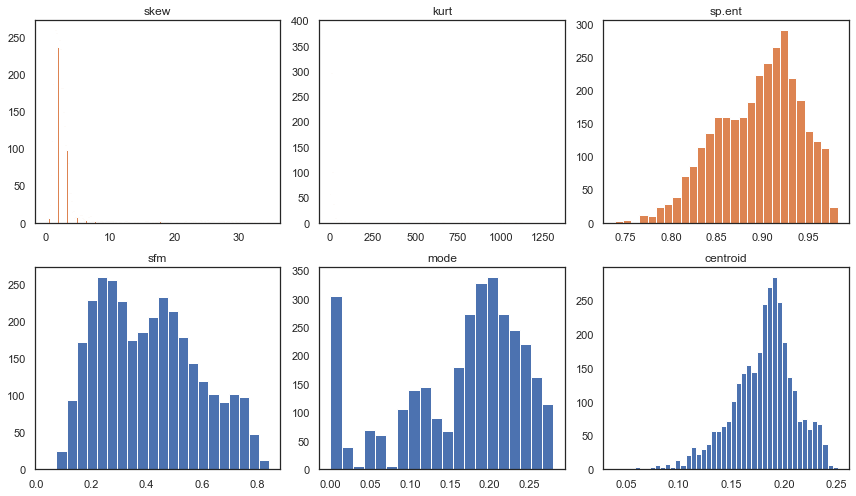

In [23]:
plt.figure(figsize=(12, 7))
plt.subplot(2, 3, 1)
plt.title("skew")
plt.hist(sound_c["skew"], bins='auto', color="C1")
plt.subplot(2, 3, 2)
plt.title("kurt")
plt.hist(sound_c["kurt"], bins='auto', color="C1")
plt.subplot(2, 3, 3)
plt.title("sp.ent")
plt.hist(sound_c["sp.ent"], bins='auto', color="C1")
plt.subplot(2, 3, 4)
plt.title("sfm")
plt.hist(sound_c["sfm"], bins='auto')
plt.subplot(2, 3, 5)
plt.title("mode")
plt.hist(sound_c["mode"], bins='auto')
plt.subplot(2, 3, 6)
plt.title("centroid")
plt.hist(sound_c["centroid"], bins='auto')
plt.tight_layout()
plt.show()

Como é possível observar alguns dos atributos tem seu histograma próximo ao formato de uma distribuição gaussiana. Abaixo, são apresentados as Densidades de Probabilidade dos mesmos dados, entretanto escalonados usado a seguinte operação:

$y = \frac{x-\mu}{\sigma}$

In [24]:
scaler = Scaler()
sound_c.loc[:]["skew"] = scaler.fit_transform(sound_c["skew"])
sound_c.loc[:]["kurt"] = scaler.fit_transform(sound_c["kurt"])
sound_c.loc[:]["sp.ent"] = scaler.fit_transform(sound_c["sp.ent"])
sound_c.loc[:]["sfm"] = scaler.fit_transform(sound_c["sfm"])
sound_c.loc[:]["mode"] = scaler.fit_transform(sound_c["mode"])
sound_c.loc[:]["centroid"] = scaler.fit_transform(sound_c["centroid"])

In [25]:
data = []
for field in ["skew", "kurt", "sp.ent", "sfm", "mode", "centroid"]:
    unique_elements, counts_elements = np.unique(sound_c[field], return_counts=True)
    data.append([
        field,
        len(sound_c[field]),
        np.round(np.min(sound_c[field]), 5),
        np.round(np.max(sound_c[field]), 5),
        np.round(np.mean(sound_c[field]), 5),
        np.round(np.median(sound_c[field]), 5),
        np.round(np.var(sound_c[field]), 5),
        np.round(np.std(sound_c[field]), 5),
        len(counts_elements)
    ])
df2 = pd.DataFrame(data, columns=["Field", "Qtd", "Min", "Max", "Mean", "Median", "Var.", "Std", "Unique"])
print(df2)

      Field   Qtd      Min      Max  Mean   Median  Var.  Std  Unique
0      skew  3168 -0.70720  7.44961  -0.0 -0.22243   1.0  1.0    3166
1      kurt  3168 -0.25573  9.43643   0.0 -0.20940   1.0  1.0    3166
2    sp.ent  3168 -3.47939  1.93162   0.0  0.14764   1.0  1.0    3166
3       sfm  3168 -2.09214  2.44922   0.0 -0.06694   1.0  1.0    3166
4      mode  3168 -2.14121  1.48616   0.0  0.27616   1.0  1.0    2825
5  centroid  3168 -4.73181  2.34737  -0.0  0.13144   1.0  1.0    3166


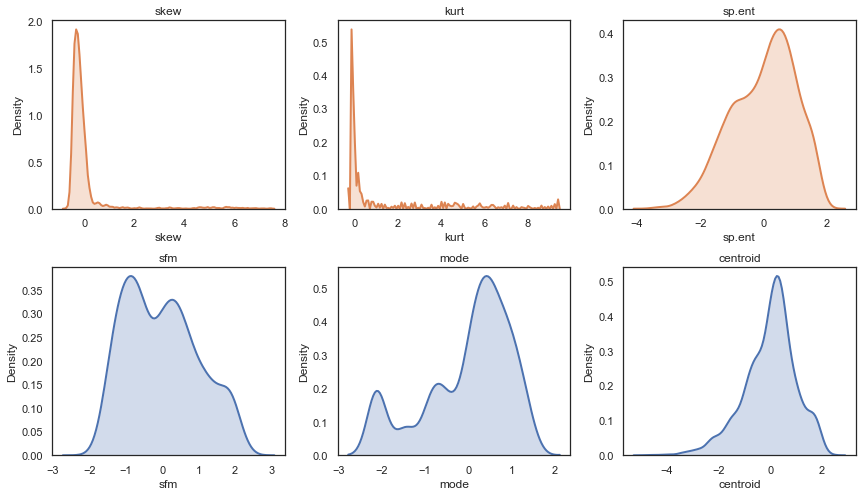

In [26]:
kds = {'shade': True, 'linewidth': 2}

plt.figure(figsize=(12, 7))
plt.subplot(2, 3, 1)
plt.title("skew")
sns.distplot(sound_c["skew"], hist=False, kde=True, kde_kws=kds, color="C1")
plt.ylabel('Density')
# sound_c["skew"].plot.kde(color="C1")
plt.subplot(2, 3, 2)
plt.title("kurt")
sns.distplot(sound_c["kurt"], hist=False, kde=True, kde_kws=kds, color="C1")
plt.ylabel('Density')
plt.subplot(2, 3, 3)
plt.title("sp.ent")
sns.distplot(sound_c["sp.ent"], hist=False, kde=True, kde_kws=kds, color="C1")
plt.ylabel('Density')
plt.subplot(2, 3, 4)
plt.title("sfm")
sns.distplot(sound_c["sfm"], hist=False, kde=True, kde_kws=kds)
plt.ylabel('Density')
plt.subplot(2, 3, 5)
plt.title("mode")
sns.distplot(sound_c["mode"], hist=False, kde=True, kde_kws=kds)
plt.ylabel('Density')
plt.subplot(2, 3, 6)
plt.title("centroid")
sns.distplot(sound_c["centroid"], hist=False, kde=True, kde_kws=kds)
plt.ylabel('Density')
plt.tight_layout()
plt.show()

Através da matriz de correlação, podemos ter uma ideia de como as features de nosso dataset estão correlacionadas entre si.

Nota-se uma correlação relativamente alta entre os campos *sfm* e *centroid*. E mais fraca entre todos os outros campos.

Evitando, encontrar apenas correlações lineares entres os valores, aplica-se também a Correlação em Distância, a qual possibilita visualizar valores de correlação não lineares entre variáveis e também avaliar a indepedência das variáveis (quando o valor for zero).

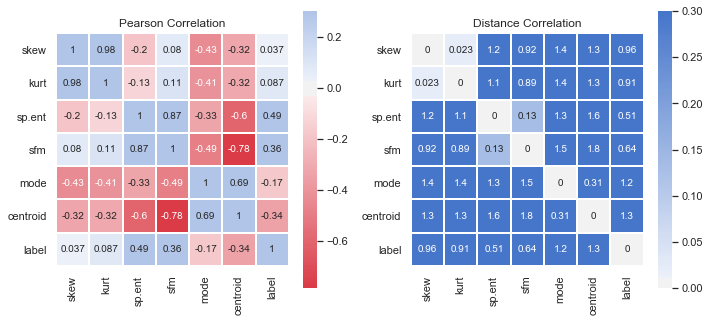

In [27]:
corr = sound_c.corr()
fields = ["skew", "kurt", "sp.ent", "sfm", "mode", "centroid", "label"]

dcorr = np.zeros((7, 7))
for i, field in enumerate(fields):
    for k, field2 in enumerate(fields):
        dcorr[i][k] = dcorrelation(sound_c[field], sound_c[field2])

cmap = sns.diverging_palette(10, 255, as_cmap=True)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.title("Pearson Correlation")
ax = sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=1, annot=True, cbar_kws={"shrink": .5})
ax.set_ylim(7, 0)
plt.subplot(1, 2, 2)
plt.title("Distance Correlation")
ax = sns.heatmap(dcorr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=1, annot=True, cbar_kws={"shrink": .5},
            xticklabels=fields, yticklabels=fields
)
ax.set_ylim(7, 0)
plt.tight_layout()
plt.show()

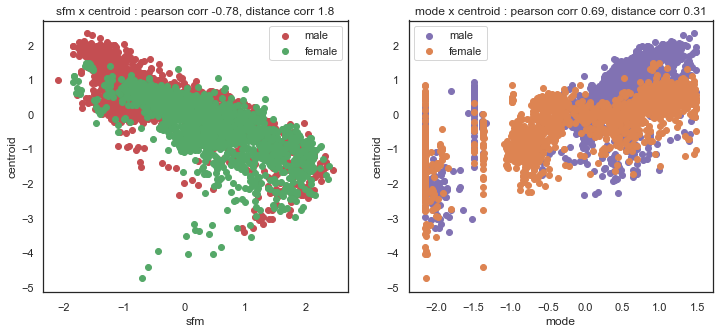

In [31]:
labels, colors, colors2 = ("male", "female"), ("C3", "C2"), ("C4", "C1")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i, color, label in zip([0, 1], colors, labels):
    sfm = sound_c[sound_c["label"] == i]["sfm"]
    centroid = sound_c[sound_c["label"] == i]["centroid"]
    plt.scatter(sfm, centroid, c=color, label=label)
plt.title("sfm x centroid : pearson corr -0.78, distance corr 1.8")
plt.xlabel("sfm")
plt.ylabel("centroid")
plt.legend()
plt.subplot(1, 2, 2)
for i, color, label in zip([0, 1], colors2, labels):
    sfm = sound_c[sound_c["label"] == i]["mode"]
    centroid = sound_c[sound_c["label"] == i]["centroid"]
    plt.scatter(sfm, centroid, c=color, label=label)
plt.title("mode x centroid : pearson corr 0.69, distance corr 0.31")
plt.xlabel("mode")
plt.ylabel("centroid")
plt.legend()
plt.show()

**b)** Implementar a Regressão Logística e apresentar os valores da curva ROC e curva F1.

In [446]:
class LogisticRegressionImpl(LinearRegressionImpl):
        
    def __sigmoid(self, z):
        z = z - np.max(z)
        return 1./(1 + np.exp(-z))
    
    def train(self, x, y, lr=1e-4, epochs=500):
        x = self._correct_X(x)
        features = y.shape[1]
        self.N = x.shape[1]
        if self.w is None:
            self.w = np.random.rand(self.N, features) * np.sqrt(2 / (self.N + features))
        J = []
        for i in range(epochs):
            yh = np.dot(x, self.w)
            J.append(np.round(self.cross_entropy(y, yh), 3))
            dw = (1 / self.N) * np.dot(x.T, (y - yh))
            self.w = (self.w + (lr * dw)) - (((lr * self._reg) / self.N) * self.w)
        return self, J
 
    def predict(self, x):
        x = self._correct_X(x)
        return np.argmax(self.__sigmoid(np.dot(x, self.w)), axis=1)

    def cross_entropy(self, y, yh):
        with np.errstate(all='ignore'):
            L2 = (self._reg / (2 * self.N)) * np.sum([np.sum(np.square(w)) for w in self.w])
            l1, l2 = np.log(yh), np.log(1 - yh)
            l1[np.isnan(l1)] = 0
            l2[np.isnan(l2)] = 0
            bce = -np.sum(np.multiply(y, l1) + np.multiply((1-y), l2))
            return ((1 / self.N) * bce) + L2

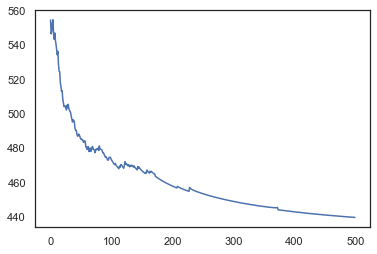

2470
698
0.7796717171717171
0.22032828282828282


In [447]:
def one_hot_encode(x, features=2):
    y = []
    for lb in labels:
        z = np.zeros((features, ))
        z[int(lb)] = 1
        y.append(z)
    return np.array(y)

x_train = sound_c[["skew", "kurt", "sp.ent", "sfm", "mode", "centroid"]]
y_train = one_hot_encode(sound_c["label"])

clf = LogisticRegressionImpl()
_, J = clf.train(x_train, y_train, lr=1e-4)

plt.plot(J)
plt.show()

acertos = 0
erros = 0
for i, a in enumerate(clf.predict(x_train)):
    if a == np.argmax(y_train[i]):
        acertos += 1
    else:
        erros += 1
print(acertos)
print(erros)
print(acertos / len(y_train))
print(erros / len(y_train))